<a href="https://colab.research.google.com/github/priyankasT16/Training/blob/master/YOLO_Darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

multiple objects recigizations using  YOLO

In [1]:
import sys

!{sys.executable} -m pip install git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-c72y3go9
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-c72y3go9
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp36-none-any.whl size=9219 sha256=1b5b96db95dcda9dab788b5056613fc428801fe99925b2b84a1a85bd8ef1fca4
  Stored in directory: /tmp/pip-ephem-wheel-cache-5qmmkswf/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


In [5]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/kaggle'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/convert.py')

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin='https://raw.githubusercontent.com/zzh8829/yolov3-tf2/master/data/coco.names')
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

8192/625 [=========================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [6]:
import sys
!{sys.executable} "{filename_convert_script}" --weights "{filename_darknet_weights}" --output "{filename_converted_weights}"


2020-03-31 12:20:19.604071: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
_________________________________________________________________________

In [0]:
import os
os.remove(filename_convert_script)

In [0]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, 'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [9]:
# This example does not use the "Tiny version"
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


In [0]:
url = "https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/cook.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

In [23]:
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence level will be ignored.)
FLAGS.yolo_score_threshold = 0.95

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:00.15


In [0]:
#print(nums[0])

In [24]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	person, 0.9995919466018677, [0.3165965  0.1072515  0.6842674  0.74258995]
	dog, 0.9896981120109558, [0.51111007 0.5576949  0.933974   0.81879807]
	microwave, 0.9839578866958618, [0.00695178 0.08101548 0.27909747 0.28820014]


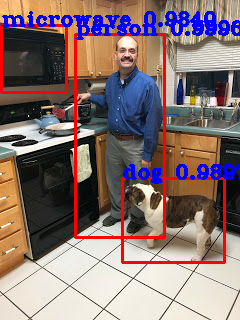

In [25]:
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image